# Bayesian Deep Active Learning

## Setup

> Train a BNN using MC Dropout on the full MNIST training dataset.

> Report the test accuracy and NLL and plot training curves for accuracy and NLL on the train set and on the test set.

In [ ]:
def get_data_loaders(batch_size=64, eval_batch_size=1024, device="cuda"):
    train_dataset_mnist= ddu_dirty_mnist.FastMNIST('./data', train=True, download=True, device=device, normalize=True)
    train_dataset_dirty_mnist = ddu_dirty_mnist.DirtyMNIST('./data', train=True, download=True, device=device, normalize=True)
    test_dataset_mnist = ddu_dirty_mnist.FastMNIST('./data', train=False, download=True, device=device, normalize=True)
    test_dataset_dirty_mnist = ddu_dirty_mnist.DirtyMNIST('./data', train=False, download=True, device=device, normalize=True)
    test_dataset_fashion = datasets.FashionMNIST('./data', train=False, download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]))

    train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True, num_workers=0)
    train_loader_dirty_mnist = DataLoader(train_dataset_dirty_mnist, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=eval_batch_size, shuffle=False, num_workers=0)
    test_loader_dirty_mnist = DataLoader(test_dataset_dirty_mnist, batch_size=eval_batch_size, shuffle=False, num_workers=0)
    test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=eval_batch_size, shuffle=False, num_workers=0)

    return train_loader_mnist,train_loader_dirty_mnist, test_loader_mnist, test_loader_dirty_mnist, test_loader_fashion

In [ ]:
train_loader_mnist,train_loader_dirty_mnist, test_loader_mnist, test_loader_dirty_mnist, test_loader_fashion =  get_data_loaders(batch_size=64, eval_batch_size=1024, device=device)


In [ ]:
# the training loop
def train_model(model, optimizer, epochs, train_loader,test_loader, device, criterion=None):
    if criterion is None:
        criterion = nn.NLLLoss()  # Default loss function

    # Move model to the specified device
    model.to(device)

    # Lists to track metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    batch_losses = []
    batch_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs, embeddings = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update statistics
            total_loss += loss.item()
            values, indices = outputs.max(1)
            total += targets.size(0)
            correct += indices.eq(targets).sum().item()

            # Track batch metrics
            batch_losses.append(loss.item())
            batch_accuracy = 100. * indices.eq(targets).sum().item() / targets.size(0)
            batch_accuracies.append(batch_accuracy)

        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = 100. * correct / total

        # Append epoch metrics to lists
        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)
        model.train()

#       evaluaation with mc_dropout
        model.train()
        with torch.no_grad():
          log_probs = mc_dropout(model,test_loader)
          # log_probs = log_probs.permute(1, 0, 2)
          test_accuracy, test_nll = compute_performance_metrics(log_probs, test_loader)
          test_losses.append(test_nll)
          test_accuracies.append(test_accuracy * 100.)

        # Print epoch statistics
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {avg_loss:.4f}, Test Loss: {test_nll:.4f}, '
              f'Train Accuracy: {avg_accuracy:.2f}% '
              f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Return the trained model and tracked metrics
    return model, train_losses, train_accuracies, batch_losses, batch_accuracies , test_losses, test_accuracies


In [ ]:
# Training the BNN
seed = 42
epochs = 10
mc = 32
mnist_model, optimizer = create_model_optimizer(seed)
MNIST_model, epoch_losses, epoch_accuracies, batch_losses, batch_accuracies ,test_losses, test_accuracies= train_model(mnist_model, optimizer, epochs, train_loader_mnist,test_loader_mnist, device)


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch [1/10], Train Loss: 0.3489, Test Loss: 0.0668, Train Accuracy: 89.35% Test Accuracy: 98.72%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


Epoch [2/10], Train Loss: 0.1490, Test Loss: 0.0660, Train Accuracy: 95.67% Test Accuracy: 98.74%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch [3/10], Train Loss: 0.1267, Test Loss: 0.0665, Train Accuracy: 96.34% Test Accuracy: 98.70%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch [4/10], Train Loss: 0.1137, Test Loss: 0.0677, Train Accuracy: 96.72% Test Accuracy: 98.69%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch [5/10], Train Loss: 0.1054, Test Loss: 0.0663, Train Accuracy: 96.96% Test Accuracy: 98.88%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Epoch [6/10], Train Loss: 0.1032, Test Loss: 0.0674, Train Accuracy: 96.94% Test Accuracy: 98.76%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


Epoch [7/10], Train Loss: 0.1005, Test Loss: 0.0670, Train Accuracy: 97.06% Test Accuracy: 98.77%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Epoch [8/10], Train Loss: 0.0956, Test Loss: 0.0665, Train Accuracy: 97.18% Test Accuracy: 98.79%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Epoch [9/10], Train Loss: 0.0958, Test Loss: 0.0659, Train Accuracy: 97.23% Test Accuracy: 98.82%


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


Epoch [10/10], Train Loss: 0.0943, Test Loss: 0.0667, Train Accuracy: 97.25% Test Accuracy: 98.74%


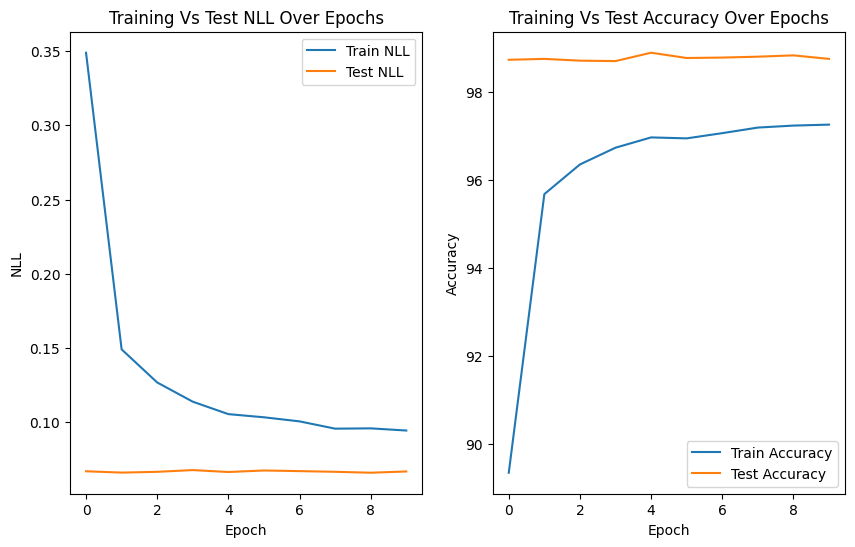

In [ ]:
# Plotting Accuracy and NLL
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Train NLL')
plt.plot(test_losses, label='Test NLL')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.title('Training Vs Test NLL Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Vs Test Accuracy Over Epochs')
plt.legend()

# Active Learning BaseLine

> Implement active learning with random acquisition, using MNIST’s training set as pool set.

> Start with 2 labeled examples per class (so 20 total) and acquire atches of 10 (K = 10) until you have 102 examples per class (1020 total).

In [ ]:
from torch.utils.data import DataLoader, Subset

# Get the data as a long 60,000 tensor
full_train_dataset = train_loader_mnist.dataset
# get the list of all target class labels
data, labels = list(full_train_dataset[:][0]), list(full_train_dataset[:][1])

#  implementing random acquisition,
labels = np.array([lab.item() for lab in labels])  # Convert labels to a numpy array
train_idx = np.arange(len(full_train_dataset)) # Cteate Training Exampples indexes

# Now create a pool of alll labeled examples by thier indices
pool = [train_idx[labels == c] for c in range(10)]

def select_k(k, indices = 0):
  choices = []
  for c in range(10):
      mini_pool = pool[c]
      random_element = np.random.choice(mini_pool, k, replace=False)
      choices.append(random_element)

      # Remove the selected elements from the mini_pool
      pool[c] = np.setdiff1d(mini_pool, random_element)

  return np.array(choices).reshape(-1,)

# k = select_k(2)

In [ ]:
# define a training loop for only subset of the data

def train_labeled(model,optimizer , labeled_indices , train_dataloade, epochs, trial = 1):
    model.to(device)
    criterion = nn.NLLLoss()

    subset = Subset(train_dataloade, indices=labeled_indices)

    subset_loader = DataLoader(subset, batch_size=32, shuffle=True)
    train_losses = []
    train_accuracies = []
    batch_losses = []
    batch_accuracies = []
    print(f'training Model for {epochs} Epochs, with {len(labeled_indices)} Labeled Data , Trial NO. {trial}')

    # Train the model
    for I in range(epochs):
          model.train()
          total_loss = 0
          correct = 0
          total = 0

          for index, (inputs, targets) in enumerate(subset_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              optimizer.zero_grad()

              # Forward pass
              outputs, embeddings = model(inputs)

              # Calculate loss
              loss = criterion(outputs, targets)

              # Backward pass and optimization
              loss.backward()
              optimizer.step()
              total_loss += loss.item()
              values, indices = outputs.max(1)
              total += targets.size(0)
              correct += indices.eq(targets).sum().item()
              # Track batch metrics
              batch_losses.append(loss.item())
              batch_accuracy = 100. * indices.eq(targets).sum().item() / targets.size(0)
              batch_accuracies.append(batch_accuracy)

        # Calculate epoch metrics
          avg_loss = total_loss / len(train_loader)
          avg_accuracy = 100. * correct / total
          # Append epoch metrics to lists
          train_losses.append(avg_loss)
          train_accuracies.append(avg_accuracy)
          final_acc = avg_accuracy

    return model, final_acc

def eval_model(model , test_loader):
  model.train()
  with torch.no_grad():
    log_probs = mc_dropout(model,test_loader)
    test_accuracy, test_nll = compute_performance_metrics(log_probs, test_loader)
  return test_accuracy *100.


## ACTIVE LEARNING LOOP

In [ ]:
epochs = 10
# geet the 20 data points
initial_subset = select_k(2)
# initialized labeled data
labeled_pool =  initial_subset
TRAIN_ACCURACIES = []
TEST_ACCURACIES = []

while len(labeled_pool) < 1021:
  seed = 42 + len(labeled_pool)
  np.random.seed(seed)
  torch.manual_seed(seed)
  train_trial_result = []
  test_trial_result = []
  for trial in range(5):
    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy = eval_model(model , test_loader_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10
  aquired = select_k(1)

  # update the labeled indices
  labeled_pool = np.concatenate([labeled_pool, aquired])

  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )



training Model with 20 Labeled Data , Trial NO. 0
training Model with 20 Labeled Data , Trial NO. 1
training Model with 20 Labeled Data , Trial NO. 2
training Model with 20 Labeled Data , Trial NO. 3
training Model with 20 Labeled Data , Trial NO. 4
 Training acc : 20.0 % | Test acc : 25.8 %
training Model with 30 Labeled Data , Trial NO. 0
training Model with 30 Labeled Data , Trial NO. 1
training Model with 30 Labeled Data , Trial NO. 2
training Model with 30 Labeled Data , Trial NO. 3
training Model with 30 Labeled Data , Trial NO. 4
 Training acc : 30.0 % | Test acc : 24.2 %
training Model with 40 Labeled Data , Trial NO. 0
training Model with 40 Labeled Data , Trial NO. 1
training Model with 40 Labeled Data , Trial NO. 2
training Model with 40 Labeled Data , Trial NO. 3
training Model with 40 Labeled Data , Trial NO. 4
 Training acc : 22.5 % | Test acc : 30.3 %
training Model with 50 Labeled Data , Trial NO. 0
training Model with 50 Labeled Data , Trial NO. 1
training Model with 5

## PLOT RESULTS

Report the learning curve (accuracy vs. number of labeled examples) averaged over 10 trials with confidence intervals.

In [ ]:
def plot_confidence_intervals(TRAIN_ACCURACIES,TEST_ACCURACIES, plot_train = True , title  =''):
  len_data = np.array([int(trial[0]) for trial in TRAIN_ACCURACIES])
  train_mean_acc = np.array([int(np.array(trial[1]).mean()) for trial in TRAIN_ACCURACIES])
  train_std = np.array([int(np.array(trial[1]).std()) for trial in TRAIN_ACCURACIES])
  test_mean_acc = np.array([int(np.array(trial[1]).mean()) for trial in TEST_ACCURACIES])
  test_std = np.array([int(np.array(trial[1]).std()) for trial in TEST_ACCURACIES])


  # Confidence intervals (mean ± std)
  train_upper = train_mean_acc + train_std
  train_lower = train_mean_acc - train_std
  test_upper = test_mean_acc + test_std
  test_lower = test_mean_acc - test_std

  # Plotting
  plt.figure(figsize=(14, 8))

  # Plot mean accuracies
  if plot_train:
    plt.plot(len_data, train_mean_acc, label='Train Accuracy', color='blue')
  plt.plot(len_data, test_mean_acc, label='Test Accuracy', color='orange')

  # Fill between for confidence intervals
  if plot_train:
    plt.fill_between(len_data, train_lower, train_upper, color='blue', alpha=0.2, label='Train CI')
  plt.fill_between(len_data, test_lower, test_upper, color='orange', alpha=0.2, label='Test CI')

  # Add labels and legend
  plt.xlabel('Number of Labeled Examples')
  plt.ylabel('Accuracy (%)')
  plt.title(f'Learning Curve with Confidence Intervals For {title} Active Learninig')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
len_data = [int(trial[0]) for trial in TRAIN_ACCURACIES]
train_mean_acc = [int(np.array(trial[1]).mean()) for trial in TRAIN_ACCURACIES]
train_std = [int(np.array(trial[1]).std()) for trial in TRAIN_ACCURACIES]
test_mean_acc = [int(np.array(trial[1]).mean()) for trial in TEST_ACCURACIES]
test_std = [int(np.array(trial[1]).std()) for trial in TEST_ACCURACIES]

In [ ]:
len_data = np.array(len_data)
train_mean_acc = np.array(train_mean_acc)
train_std = np.array(train_std)
test_mean_acc = np.array(test_mean_acc)
test_std = np.array(test_std)

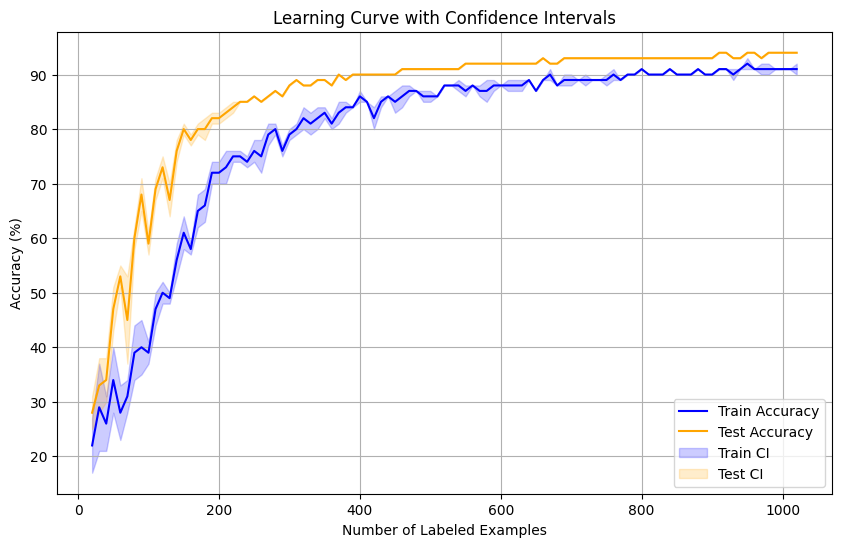

In [ ]:
# Confidence intervals (mean ± std)
train_upper = train_mean_acc + train_std
train_lower = train_mean_acc - train_std
test_upper = test_mean_acc + test_std
test_lower = test_mean_acc - test_std

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean accuracies
plt.plot(len_data, train_mean_acc, label='Train Accuracy', color='blue')
plt.plot(len_data, test_mean_acc, label='Test Accuracy', color='orange')

# Fill between for confidence intervals
plt.fill_between(len_data, train_lower, train_upper, color='blue', alpha=0.2, label='Train CI')
plt.fill_between(len_data, test_lower, test_upper, color='orange', alpha=0.2, label='Test CI')

# Add labels and legend
plt.xlabel('Number of Labeled Examples')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

# Random Acquisition Scaling Behavior:


## BNN MODEL MNIST

1. Choose 5 labeled examples per class and train the BNN with varying the number of training epochs between 1 and 2048

In [ ]:
# CHOOSING 5 TRAINING EXAMPLES
initial_subset = select_k(5)


# INITIALIZE A DATALOADER WITH THIS SUBSET
subset = Subset(full_train_dataset, indices=initial_subset)
subset_loader = DataLoader(subset, batch_size=32, shuffle=True)

# Define geometric progression for epochs
epochs_list = np.geomspace(start=1, stop=2048, num=12, dtype=int)

# TO SAVE RESULTS
test_accuracies = []
test_nlls = []
# TRAINING
for epochs in epochs_list:
    print(f"Training for {epochs} epochs")
    model, optimizer = create_model_optimizer(seed=42)
    model.to(device)

    # train model
    train_model(model, optimizer, epochs, subset_loader, test_loader_mnist, device)

    # Evaluate model
    log_probs = mc_dropout(model, test_loader_mnist)  # Shape: (n_samples, batch_size, num_classes)
    accuracy, nll = compute_performance_metrics(log_probs, test_loader_mnist)
    # Store results
    test_accuracies.append(accuracy * 100)  # Convert to percentage
    test_nlls.append(nll)

    print(f"Epochs: {epochs} | Test Accuracy: {accuracy * 100:.2f}% | NLL: {nll:.4f}")


Training for 1 epochs
Epoch [1/1], Train Loss: 2.4072, Test Loss: 2.2814, Train Accuracy: 6.00% Test Accuracy: 19.23%
Epochs: 1 | Test Accuracy: 19.20% | NLL: 2.2828
Training for 2 epochs
Epoch [1/2], Train Loss: 2.4072, Test Loss: 2.2814, Train Accuracy: 6.00% Test Accuracy: 19.23%
Epoch [2/2], Train Loss: 2.2658, Test Loss: 2.2565, Train Accuracy: 22.00% Test Accuracy: 21.81%
Epochs: 2 | Test Accuracy: 22.75% | NLL: 2.2554
Training for 4 epochs
Epoch [1/4], Train Loss: 2.4072, Test Loss: 2.2814, Train Accuracy: 6.00% Test Accuracy: 19.23%
Epoch [2/4], Train Loss: 2.2658, Test Loss: 2.2565, Train Accuracy: 22.00% Test Accuracy: 21.79%
Epoch [3/4], Train Loss: 2.3452, Test Loss: 2.2353, Train Accuracy: 12.00% Test Accuracy: 17.23%
Epoch [4/4], Train Loss: 2.2758, Test Loss: 2.2175, Train Accuracy: 14.00% Test Accuracy: 17.34%
Epochs: 4 | Test Accuracy: 16.83% | NLL: 2.2172
Training for 7 epochs
Epoch [1/7], Train Loss: 2.4072, Test Loss: 2.2814, Train Accuracy: 6.00% Test Accuracy: 19.

## Plot the test accuracy and NLL against the number of epochs (log scale).

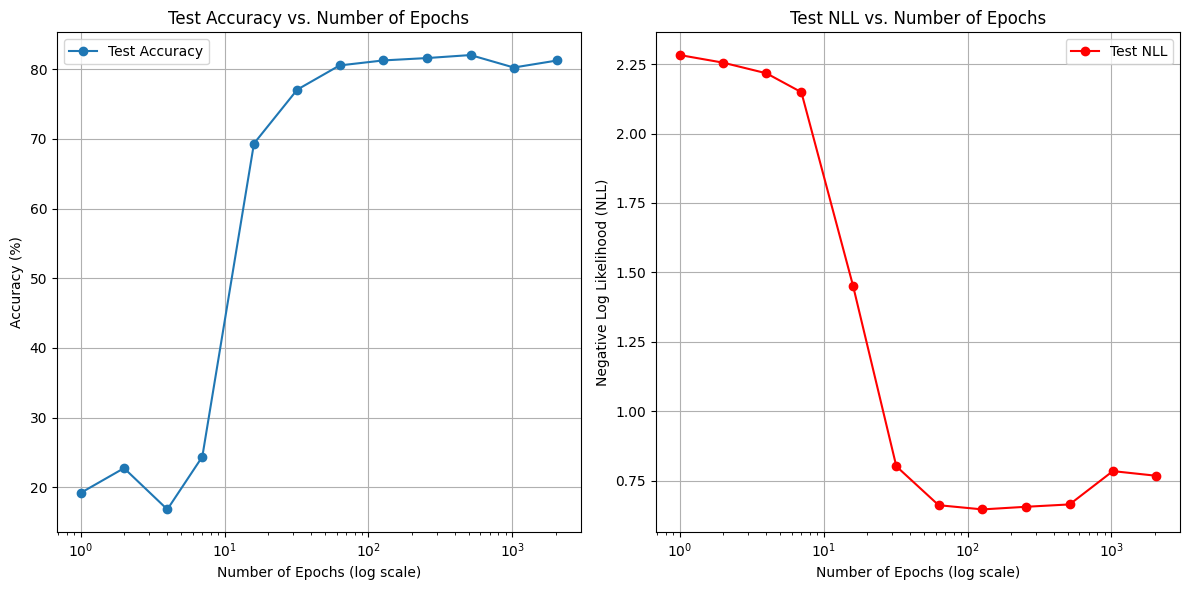

In [ ]:
# Plotting results
plt.figure(figsize=(12, 6))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_list, test_accuracies, marker='o', label='Test Accuracy')
plt.xscale('log')  # Logarithmic scale for epochs
plt.xlabel('Number of Epochs (log scale)')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Number of Epochs')
plt.grid(True)
plt.legend()

# Plot NLL
plt.subplot(1, 2, 2)
plt.plot(epochs_list, test_nlls, marker='o', color='red', label='Test NLL')
plt.xscale('log')  # Logarithmic scale for epochs
plt.xlabel('Number of Epochs (log scale)')
plt.ylabel('Negative Log Likelihood (NLL)')
plt.title('Test NLL vs. Number of Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 2. Now repeat this experiment with different numbers of labeled examples per class (e.g., 2, 4, 8, 16, 32) using 10 training epochs and plot the performance against the number of examples (log scale).

In [ ]:
labeled_per_class = [2, 4, 8, 16, 32 , 64 , 128 ,256,512]
epochs = 10
num_labeled_examples = []
test_accuracies = []
test_nlls = []
for k in labeled_per_class:
    print(f"Training with {k} labeled examples per class")
    labeled_indices = select_k(k)
    model, optimizer = create_model_optimizer(seed=42)
    train_labeled(model, optimizer, labeled_indices, full_train_dataset, epochs)
    log_probs = mc_dropout(model, test_loader_mnist)  # Shape: (n_samples, batch_size, num_classes)
    accuracy, nll = compute_performance_metrics(log_probs, test_loader_mnist)
    # Store results
    num_examples = k * 10
    num_labeled_examples.append(num_examples)
    test_accuracies.append(accuracy * 100)
    test_nlls.append(nll)

    print(f"Labeled Examples: {num_examples} | Test Accuracy: {accuracy * 100:.2f}% | NLL: {nll:.4f}")



Training with 2 labeled examples per class
training Model with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


Labeled Examples: 20 | Test Accuracy: 21.51% | NLL: 2.1886
Training with 4 labeled examples per class
training Model with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Labeled Examples: 40 | Test Accuracy: 38.67% | NLL: 2.1561
Training with 8 labeled examples per class
training Model with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Labeled Examples: 80 | Test Accuracy: 60.53% | NLL: 1.7557
Training with 16 labeled examples per class
training Model with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Labeled Examples: 160 | Test Accuracy: 80.00% | NLL: 0.8910
Training with 32 labeled examples per class
training Model with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


Labeled Examples: 320 | Test Accuracy: 89.21% | NLL: 0.4798
Training with 64 labeled examples per class
training Model with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Labeled Examples: 640 | Test Accuracy: 93.24% | NLL: 0.2977
Training with 128 labeled examples per class
training Model with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


Labeled Examples: 1280 | Test Accuracy: 95.26% | NLL: 0.2193
Training with 256 labeled examples per class
training Model with 2560 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


Labeled Examples: 2560 | Test Accuracy: 96.73% | NLL: 0.1411
Training with 512 labeled examples per class
training Model with 5120 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Labeled Examples: 5120 | Test Accuracy: 97.84% | NLL: 0.1064


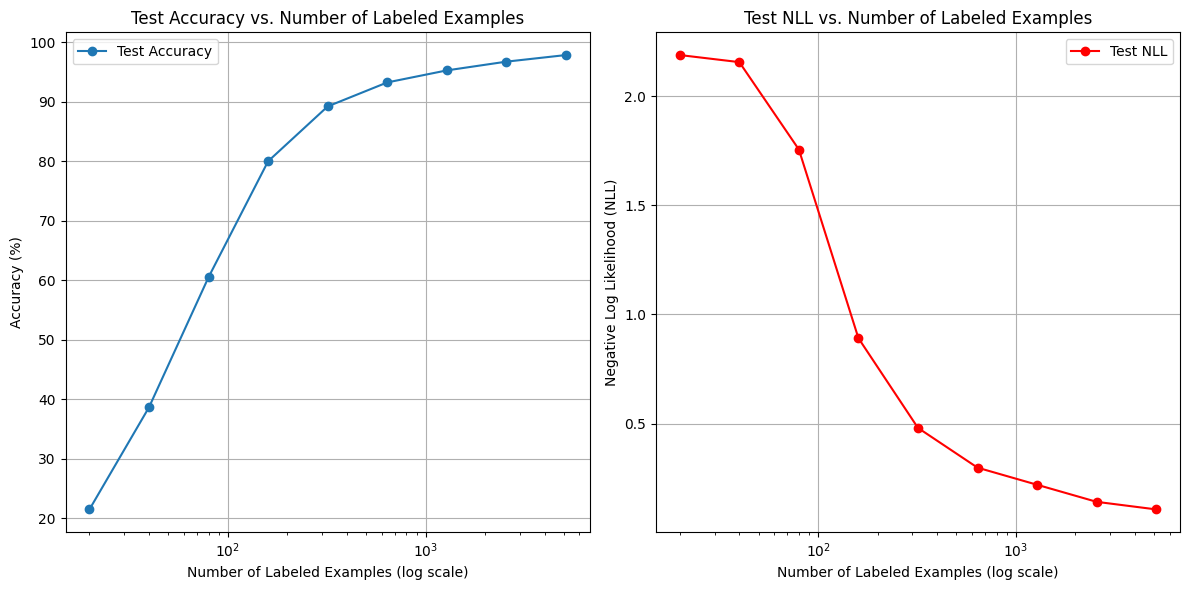

In [ ]:
# Plotting results
plt.figure(figsize=(12, 6))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_labeled_examples, test_accuracies, marker='o', label='Test Accuracy')
plt.xscale('log')  # Logarithmic scale for number of examples
plt.xlabel('Number of Labeled Examples (log scale)')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy vs. Number of Labeled Examples')
plt.grid(True)
plt.legend()

# Plot NLL
plt.subplot(1, 2, 2)
plt.plot(num_labeled_examples, test_nlls, marker='o', color='red', label='Test NLL')
plt.xscale('log')  # Logarithmic scale for number of examples
plt.xlabel('Number of Labeled Examples (log scale)')
plt.ylabel('Negative Log Likelihood (NLL)')
plt.title('Test NLL vs. Number of Labeled Examples')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**We can see that just few data point achieve significant performance, compared for trainin for long with little data, which takes so long to achieve same results as training with few examples**

**This tells us that Active learning is indeed important, which will help us achieve high accuracies with few data**

## 4. Repeat the random acquisition experiment with your new insights and plot the active learning performance curves with confidence intervals from before and after.

**Heuristic**

My Idea is to decraese the no. of epochs as I increase th no. of samples I train the model on, so I wil use to lists,

Epochs lists: A geometric Seriris that goes from 1024 down to 2 epochs
labeled Samples_k : no of training examples for each trial, which will will be inversly proportional to the epoch list, starting with 50 examples, ending with 1000

In [ ]:
#  Trianning by increasing data points
# Define geometric progression for epochs
def get_epoch(labeled_pool):
  if len(labeled_pool) < 100 :
    epochs = 200
  elif len(labeled_pool) < 400:
    epochs = 100
  elif len(labeled_pool) < 1000:
    epochs = 50
  else:
    epochs = 10
  return epochs

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 , 128]
# Define geometric progression for epochs
epochs_list = np.geomspace(start=1, stop=2048, num=12, dtype=int)

# get the 20 data points
# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
Heuristic_TRAIN_ACCURACIES = []
Heuristic_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)
    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy = eval_model(model , test_loader_mnist)
    #  track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  Heuristic_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  Heuristic_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10
  aquired = select_k(samples)

  # update the labeled indices
  labeled_pool = np.concatenate([labeled_pool, aquired])

  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )



training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


 Training acc : 100.0 % | Test acc : 56.0 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


 Training acc : 100.0 % | Test acc : 59.6 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


 Training acc : 97.5 % | Test acc : 72.5 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


 Training acc : 100.0 % | Test acc : 81.3 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


 Training acc : 100.0 % | Test acc : 87.6 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


 Training acc : 98.8 % | Test acc : 93.1 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


 Training acc : 97.0 % | Test acc : 94.8 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


 Training acc : 92.1 % | Test acc : 94.8 %


 PLOT RESULTS

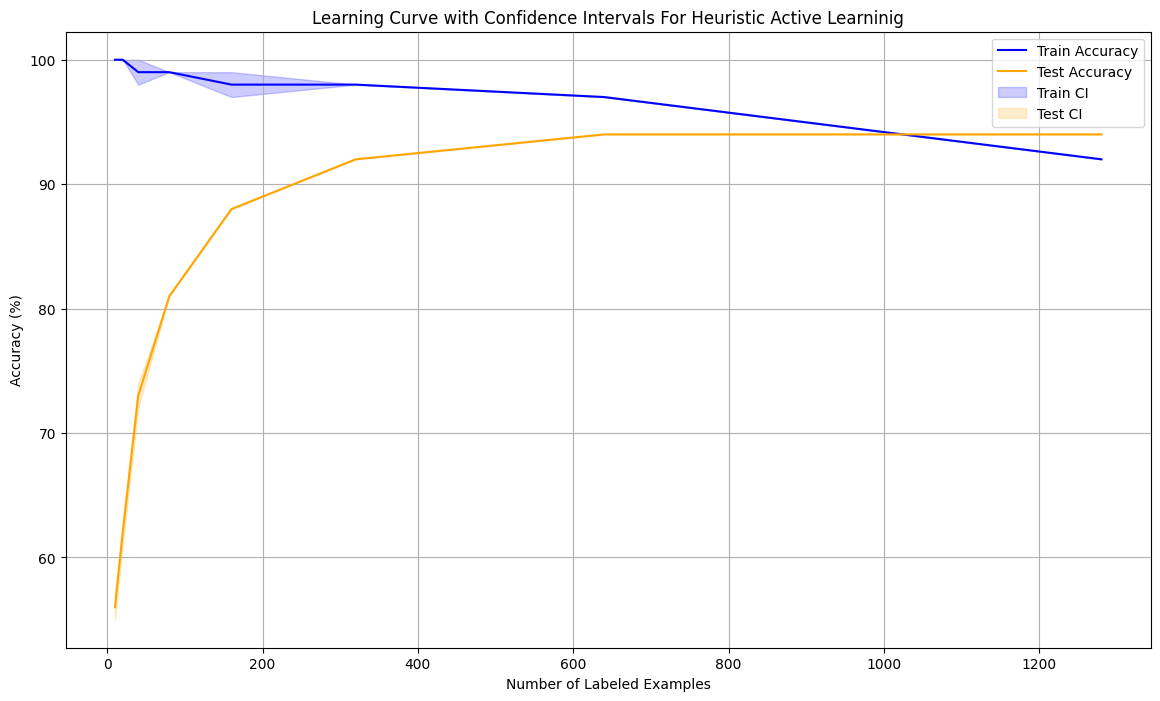

In [ ]:
plot_confidence_intervals(Heuristic_TRAIN_ACCURACIES,Heuristic_TEST_ACCURACIES , title  ='Heuristic')

**comment**

training accuracy starts from high up because of the huristic that lets the model train on few datapoint form many epochs, making the model overfit on the that small training set

##### (5p) Margin Sampling: Implement margin sampling as acquisition function. Compare its performance to random acquisition over 10 trials, plotting learning curves with confidence intervals. Plot all your results so far in a single plot. Hint: For margin sampling, we select the samples with the smallest margin between the two most likely classes.

In [ ]:
def margin_sampling(labeled_indices, unlabeled_pool, full_train_dataset , k):
  sampled_indices = labeled_indices

  for cls,mini_pool in enumerate(unlabeled_pool):
    margins = []
    model.eval()
    with torch.no_grad():
      subset = Subset(full_train_dataset, indices=mini_pool)
      subset_loader = DataLoader(subset, shuffle=False)
      for i,(input, target) in enumerate(subset_loader):
        log_probs,_ = model(input)
        probs = log_probs.exp()
        sorted_probs = np.sort(probs.cpu(), axis=1)
        margin = sorted_probs[:,-1] - sorted_probs[:,-2]
        margins.append(margin.item())
    top_k_min_indices = np.argsort(np.array(margins))[:k]
    indices_to_remove = np.array(mini_pool)[top_k_min_indices]
    sampled_indices = np.concatenate((sampled_indices, indices_to_remove))
    unlabeled_pool[cls] = np.setdiff1d(mini_pool, indices_to_remove)

  return sampled_indices , unlabeled_pool
def get_epoch(labeled_pool):
  if len(labeled_pool) < 100 :
    epochs = 200
  elif len(labeled_pool) < 400:
    epochs = 100
  elif len(labeled_pool) < 1000:
    epochs = 50
  else:
    epochs = 10
  return epochs


In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 , 128]
# Define geometric progression for epochs
epochs_list = np.geomspace(start=1, stop=2048, num=12, dtype=int)

# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
margin_TRAIN_ACCURACIES = []
margin_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)

    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy = eval_model(model , test_loader_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  margin_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  margin_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  margin_sampling(labeled_pool, unlabeled_pool, full_train_dataset , samples)


  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


 Training acc : 100.0 % | Test acc : 48.9 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


 Training acc : 100.0 % | Test acc : 61.6 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


 Training acc : 97.5 % | Test acc : 71.4 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


 Training acc : 100.0 % | Test acc : 85.7 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


 Training acc : 98.8 % | Test acc : 92.5 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


 Training acc : 97.2 % | Test acc : 95.8 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


 Training acc : 89.2 % | Test acc : 97.2 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


 Training acc : 63.0 % | Test acc : 96.3 %


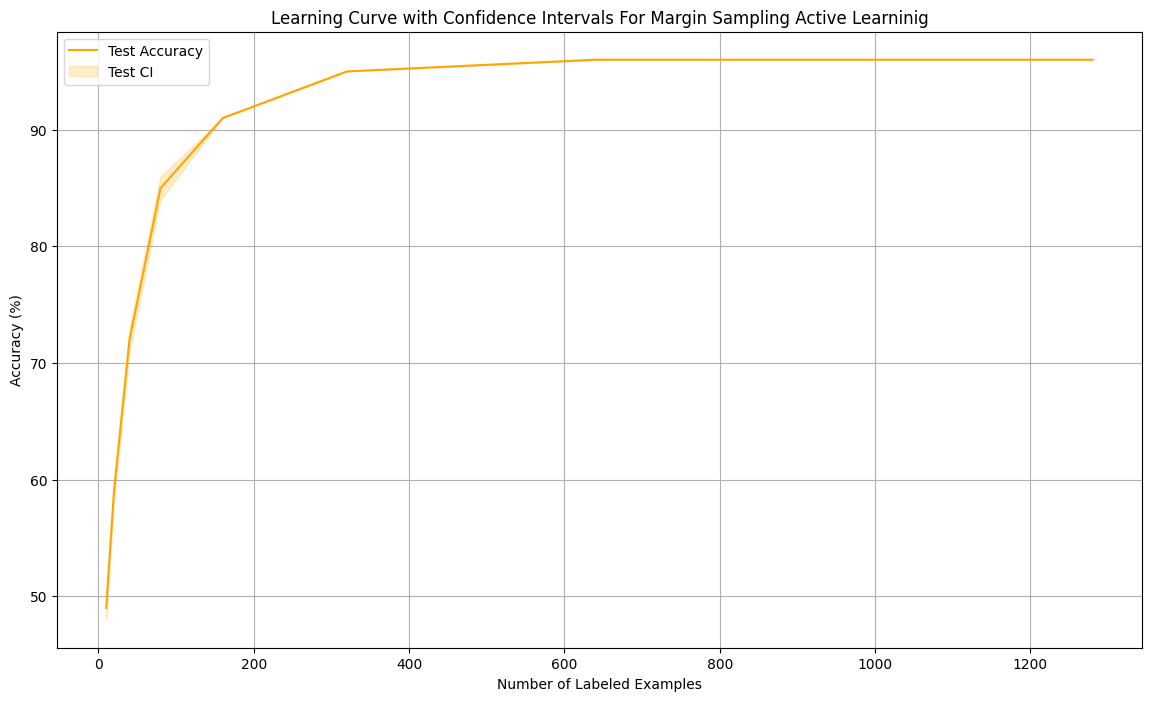

In [ ]:
plot_confidence_intervals(margin_TRAIN_ACCURACIES,margin_TEST_ACCURACIES ,plot_train = False, title ='Margin Sampling')

In [ ]:
import pickle

# Data to save
data_to_save = {
    "Heuristic_TRAIN_ACCURACIES": Heuristic_TRAIN_ACCURACIES,
    "Heuristic_TEST_ACCURACIES": Heuristic_TEST_ACCURACIES,
    "margin_TRAIN_ACCURACIES": margin_TRAIN_ACCURACIES,
    "margin_TEST_ACCURACIES": margin_TEST_ACCURACIES
}

# Save to pickle file
with open("accuracies.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

print("Data saved to accuracies.pkl")


Data saved to accuracies.pkl


##### (5p) BALD: Implement BALD as an acquisition function and evaluate it using 10 trials. Compare its performance to the previous methods. Hint: Use the same number of MC dropout samples as in Part 2

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]
def Bald_sampling(model , labeled_indices, unlabeled_pool, full_train_dataset , k):
  sampled_indices = labeled_indices

  for cls,mini_pool in enumerate(unlabeled_pool):
    subset = Subset(full_train_dataset, indices=mini_pool)
    subset_loader = DataLoader(subset,batch_size=1024 ,shuffle=False)

    log_probs = mc_dropout(model, subset_loader, n =32)
    uncertainties = compute_uncertainties(log_probs)

    _,_,_,epistemic_uncertainty = uncertainties

    top_k_min_indices = np.argsort(np.array(epistemic_uncertainty.cpu()))[:k]
    indices_to_remove = np.array(mini_pool)[top_k_min_indices]
    sampled_indices = np.concatenate((sampled_indices, indices_to_remove))
    unlabeled_pool[cls] = np.setdiff1d(mini_pool, indices_to_remove)

  return sampled_indices , unlabeled_pool

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 , 128]
# Define geometric progression for epochs
epochs_list = np.geomspace(start=1, stop=2048, num=12, dtype=int)

# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
Bald_TRAIN_ACCURACIES = []
Bald_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)

    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy     =  eval_model(model , test_loader_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  Bald_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  Bald_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  Bald_sampling(model,labeled_pool, unlabeled_pool, full_train_dataset, samples )


  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]


 Training acc : 100.0 % | Test acc : 55.4 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


 Training acc : 95.0 % | Test acc : 59.0 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


 Training acc : 100.0 % | Test acc : 59.1 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


 Training acc : 100.0 % | Test acc : 65.7 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


 Training acc : 99.4 % | Test acc : 67.0 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]


 Training acc : 100.0 % | Test acc : 67.7 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


 Training acc : 99.8 % | Test acc : 70.7 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


 Training acc : 99.1 % | Test acc : 69.1 %


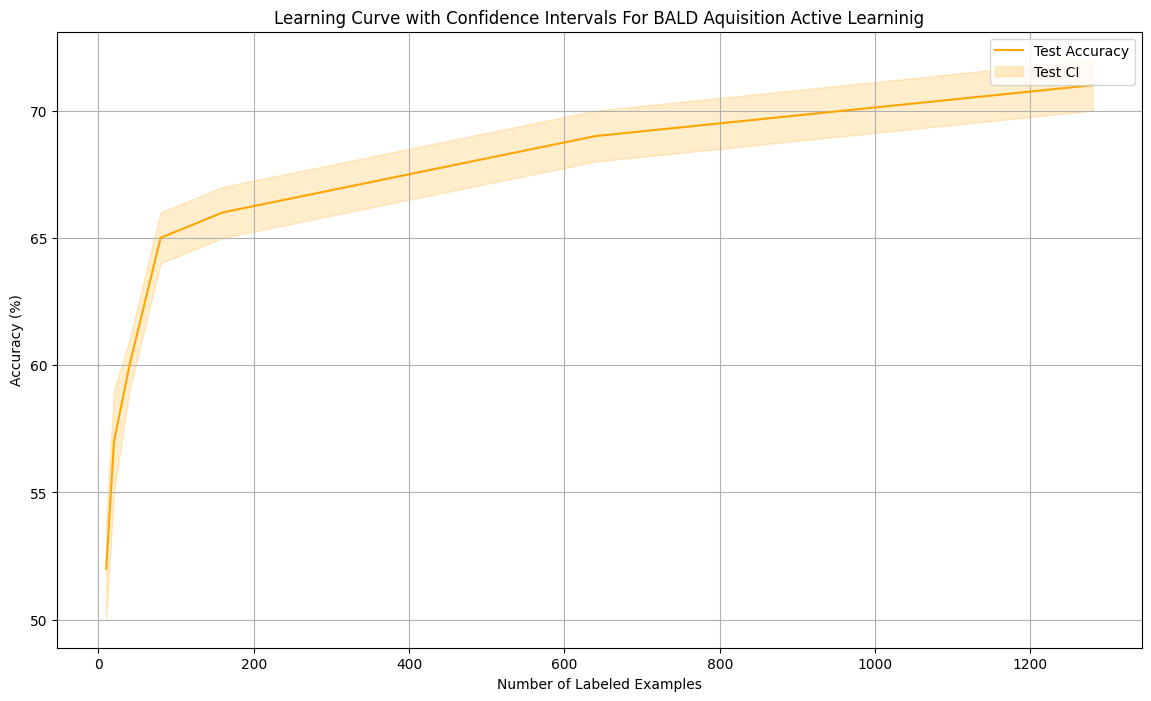

In [ ]:
plot_confidence_intervals(Bald_TRAIN_ACCURACIES ,Bald_TEST_ACCURACIES ,plot_train = False, title ='BALD Aquisition')

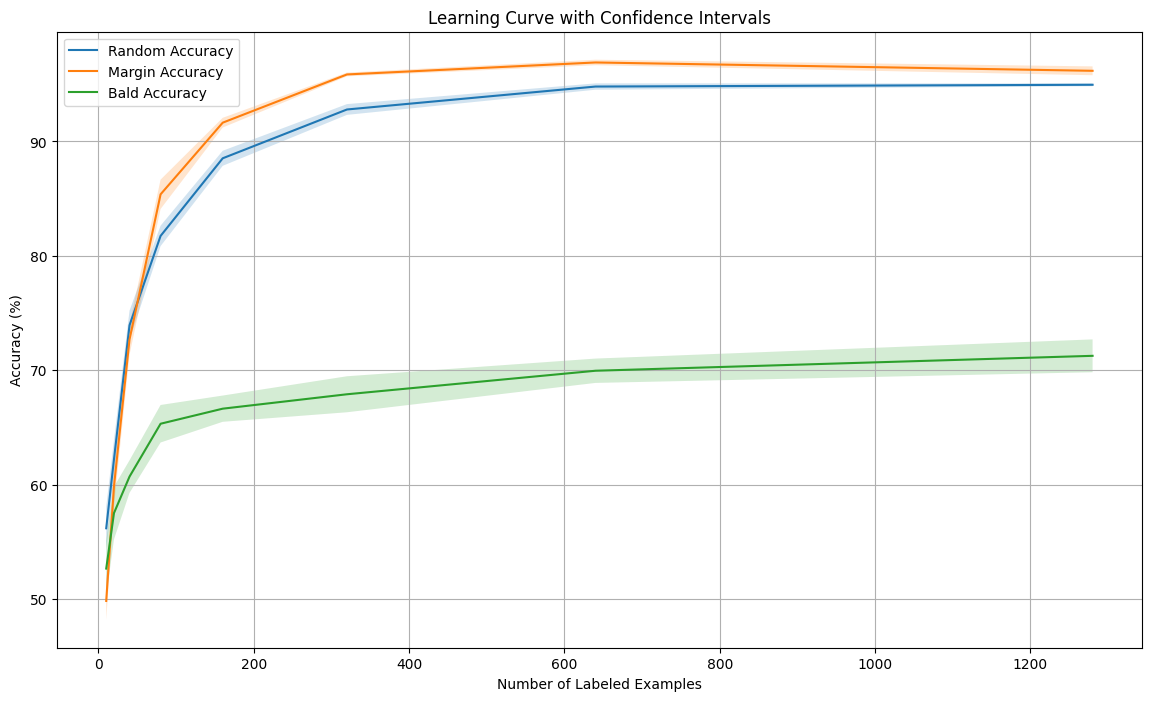

In [ ]:
def plot_learning_curve_with_ci(test_accuracies_dict, len_data, title="Learning Curve with Confidence Intervals"):
    # Plotting
    plt.figure(figsize=(14, 8))

    # Iterate over the test accuracies dictionary
    for method_name, accuracies in test_accuracies_dict.items():
        # Extract mean accuracy and standard deviation
        mean_acc = np.array([np.mean(np.array(trial[1])) for trial in accuracies])
        std_acc = np.array([np.std(np.array(trial[1])) for trial in accuracies])

        # Compute confidence intervals (mean ± std)
        upper = mean_acc + std_acc
        lower = mean_acc - std_acc

        # Plot the mean accuracy
        plt.plot(len_data, mean_acc, label=f'{method_name} Accuracy')

        # Fill the confidence intervals
        plt.fill_between(len_data, lower, upper, alpha=0.2)

    # Add labels and legend
    plt.xlabel('Number of Labeled Examples')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.legend()
    plt.grid()

    # Display the plot
    plt.show()

test_accuracies_dict = {
    'Random': Heuristic_TEST_ACCURACIES,
    'Margin': margin_TEST_ACCURACIES,
    'Bald': Bald_TEST_ACCURACIES
}

len_data = np.array([int(trial[0]) for trial in margin_TEST_ACCURACIES])  # Replace with your data

# Call the function
plot_learning_curve_with_ci(test_accuracies_dict, len_data)


***Comment***


**In this learning curve plot, we can observe that Margin (represented by the red line) consistently outperforms the other methods, showing the highest accuracy across the trials. On the other hand, BALD (shown by the pink line) shows relatively poor performance, indicating that this acquisition function did not effectively improve the model's accuracy in this case. Therefore, Margin appears to be the most effective acquisition strategy, while BALD did not show significant improvements.**

In [ ]:
def save_model(model, optimizer, epoch, loss, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, file_path)
save_model(model, optimizer,10, train_acc, "./Bald_Model.pth")

In [ ]:
def load_model(model, optimizer, file_path):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


#### 6. (Optional 5p) Top-K Trade-Offs: Additionally, run BALD with k = 1 (individual acquisitions) for 20 steps, starting from a model checkpoint trained with BALD and k = 10 at 10 samples per class. Compare the performance of k = 1 and k = 10 and discuss your observations. Hint: Consider the computational cost and the performance gain of using k = 1 vs. k = 10.


***BALD with k = 1***

In [ ]:
# get the last trained Bald Model
Bald_model = model
# Bald_model

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]
# get the 20 data points
# initialized labeled data
labeled_pool =  select_k(1)
k1_Bald_TRAIN_ACCURACIES = []
k1_Bald_TEST_ACCURACIES = []

for i in range(20) :
  seed = 42 + len(labeled_pool)
  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)
  for trial in range(10):
    model = Bald_model
    np.random.seed(seed) ;  torch.manual_seed(seed)

    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy     =  eval_model(model , test_loader_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  k1_Bald_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  k1_Bald_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  Bald_sampling(model,labeled_pool, unlabeled_pool, full_train_dataset, 1 )

  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


 Training acc : 100.0 % | Test acc : 65.5 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


 Training acc : 100.0 % | Test acc : 62.7 %
training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 30 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


 Training acc : 100.0 % | Test acc : 60.8 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 66.6 %
training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 50 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


 Training acc : 100.0 % | Test acc : 64.2 %
training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 60 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 62.7 %
training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 200 Epochs, with 70 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 63.6 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


 Training acc : 100.0 % | Test acc : 57.1 %
training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 200 Epochs, with 90 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


 Training acc : 100.0 % | Test acc : 59.3 %
training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


 Training acc : 100.0 % | Test acc : 59.5 %
training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 110 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 58.9 %
training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 120 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 60.5 %
training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 130 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


 Training acc : 100.0 % | Test acc : 58.9 %
training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 140 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 65.8 %
training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 150 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


 Training acc : 100.0 % | Test acc : 61.6 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]


 Training acc : 100.0 % | Test acc : 60.4 %
training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 170 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]


 Training acc : 100.0 % | Test acc : 60.5 %
training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 100 Epochs, with 180 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 58.8 %
training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 190 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 60.4 %
training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 61.3 %


**Bald with k = 10**

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

# get the 20 data points
# initialized labeled data
labeled_pool =  select_k(10)
k10_Bald_TRAIN_ACCURACIES = []
k10_Bald_TEST_ACCURACIES = []

# get the last trained Bald Model

for i in range(20) :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    model = Bald_model

    np.random.seed(seed) ;  torch.manual_seed(seed)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy     =  eval_model(model , test_loader_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  k10_Bald_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  k10_Bald_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

  # update the labeled indices
  labeled_pool,unlabeled_pool=  Bald_sampling(model,labeled_pool, unlabeled_pool, full_train_dataset, 10 )

  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 100 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


 Training acc : 100.0 % | Test acc : 87.7 %
training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


training Model for 100 Epochs, with 200 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


 Training acc : 99.5 % | Test acc : 87.7 %
training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 100 Epochs, with 300 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 99.7 % | Test acc : 87.5 %
training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 50 Epochs, with 400 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


 Training acc : 100.0 % | Test acc : 87.4 %
training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 500 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]


 Training acc : 99.8 % | Test acc : 86.8 %
training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 600 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


 Training acc : 100.0 % | Test acc : 87.8 %
training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


training Model for 50 Epochs, with 700 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


 Training acc : 99.6 % | Test acc : 86.6 %
training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


training Model for 50 Epochs, with 800 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]


 Training acc : 100.0 % | Test acc : 86.9 %
training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 50 Epochs, with 900 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


 Training acc : 99.9 % | Test acc : 87.8 %
training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1000 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 86.7 %
training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1100 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


 Training acc : 99.9 % | Test acc : 87.1 %
training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1200 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


 Training acc : 100.0 % | Test acc : 86.8 %
training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1300 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 87.3 %
training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1400 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 100.0 % | Test acc : 87.3 %
training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1500 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


 Training acc : 99.7 % | Test acc : 86.8 %
training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1600 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


 Training acc : 100.0 % | Test acc : 86.3 %
training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1700 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


 Training acc : 100.0 % | Test acc : 86.6 %
training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1800 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


 Training acc : 99.9 % | Test acc : 87.2 %
training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


training Model for 10 Epochs, with 1900 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


 Training acc : 99.8 % | Test acc : 86.6 %
training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


training Model for 10 Epochs, with 2000 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


 Training acc : 100.0 % | Test acc : 86.7 %


**Compare the performance**

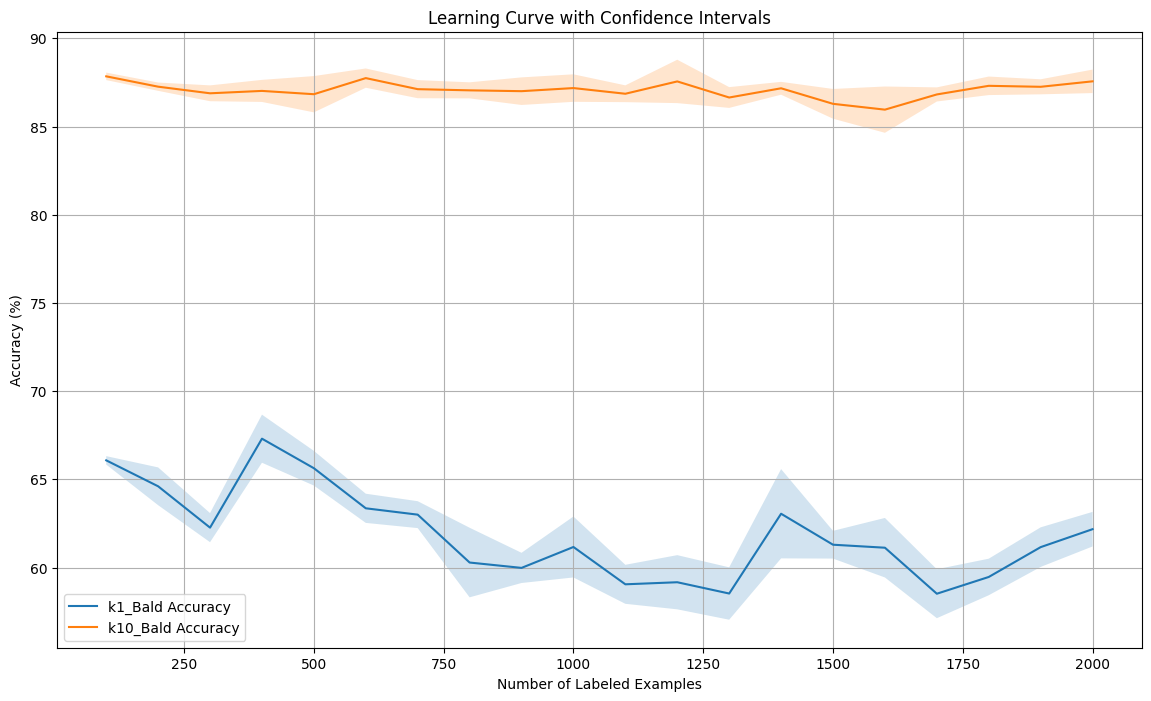

In [ ]:
test_accuracies_dict = {
    'k1_Bald': k1_Bald_TEST_ACCURACIES,
    'k10_Bald': k10_Bald_TEST_ACCURACIES
}

len_data = np.array([int(trial[0]) for trial in k10_Bald_TEST_ACCURACIES])  # Replace with your data


# Call the function
plot_learning_curve_with_ci(test_accuracies_dict, len_data)

##### Summary of Results:

The \(k=10\) BALD strategy outperforms \(k=1\) in accuracy, stability, and efficiency. \(k=10\) achieves higher and more stable performance (85–90% accuracy) compared to \(k=1\), which fluctuates around 60–65%. While \(k=1\) has lower computational cost per step, its frequent updates and variability make it less efficient overall. \(k=10\) balances computational cost with better and faster learning, making it the preferred approach in this scenario.

# Dirty-MNIST

## Baseline: Evaluate entropy, margin sampling, and BALD acquisition using DirtyMNIST’s training set as pool set and evaluate on Dirty-MNIST’s test set. Compare their performance over 10 trials, plotting learning curves with confidence intervals.

In [ ]:
_,train_loader_dirty_mnist, _, test_loader_dirty_mnist, _ =  get_data_loaders(batch_size=64, eval_batch_size=1024, device=device)
# Assuming train_loader_dirty_mnist is already defined and contains the dataset
full_train_dataset = train_loader_dirty_mnist.dataset

# Extract the data and labels
data = []
labels = []
for sample, label in full_train_dataset:
    data.append(sample)
    labels.append(label)
data = torch.stack(data)  # Combine all tensors into a single tensor
labels = torch.tensor(labels)  # Convert list of labels to a tensor

# random acquisition
labels = labels.numpy()  # Convert labels to a numpy array
train_idx = np.arange(len(full_train_dataset))  # Create Training Examples indices

# Create a pool of all labeled examples by their indices
unlabeled_pool = [train_idx[labels == c] for c in range(10)]  # Group indices by class

In [ ]:
# unlabeled_pool[0].shape

#### Evaluate entropy

In [ ]:
def entropy_sampling(model , labeled_indices, unlabeled_pool, full_train_dataset , k):
  sampled_indices = labeled_indices

  for cls,mini_pool in enumerate(unlabeled_pool):
    subset = Subset(full_train_dataset, indices=mini_pool)
    subset_loader = DataLoader(subset,batch_size=1024 ,shuffle=False)

    log_probs = mc_dropout(model, subset_loader, n =32)
    uncertainties = compute_uncertainties(log_probs)

    predictive_uncertainty = uncertainties[1]

    top_k_min_indices = np.argsort(np.array(predictive_uncertainty.cpu()))[:k]
    indices_to_remove = np.array(mini_pool)[top_k_min_indices]
    sampled_indices = np.concatenate((sampled_indices, indices_to_remove))
    unlabeled_pool[cls] = np.setdiff1d(mini_pool, indices_to_remove)

  return sampled_indices , unlabeled_pool

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 , 128]

# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
entropy_TRAIN_ACCURACIES = []
entropy_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)

    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy = eval_model(model , test_loader_dirty_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  entropy_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  entropy_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  entropy_sampling(model,labeled_pool, unlabeled_pool, full_train_dataset , samples)



  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.45it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.84it/s]


 Training acc : 100.0 % | Test acc : 30.9 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


 Training acc : 95.0 % | Test acc : 38.2 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 100.0 % | Test acc : 37.5 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 98.8 % | Test acc : 36.0 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 99.4 % | Test acc : 40.1 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


 Training acc : 99.4 % | Test acc : 42.3 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


 Training acc : 99.2 % | Test acc : 45.3 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


 Training acc : 97.3 % | Test acc : 51.1 %


In [ ]:
import pickle
# Data to save
data_to_save = {
    "entropy_TRAIN_ACCURACIES": entropy_TRAIN_ACCURACIES,
    "entropy_TEST_ACCURACIES": entropy_TEST_ACCURACIES,

}

# Save to pickle file
with open("entropy_accuracies.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

print("Data saved to entropy_accuracies.pkl")


Data saved to entropy_accuracies.pkl


#### Margin Sampling

In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 ,128]
# Define geometric progression for epochs
epochs_list = np.geomspace(start=1, stop=2048, num=12, dtype=int)

# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
margin_TRAIN_ACCURACIES = []
margin_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)

    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy = eval_model(model , test_loader_dirty_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  margin_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  margin_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  margin_sampling(labeled_pool, unlabeled_pool, full_train_dataset , samples)


  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.44it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.45it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.42it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


 Training acc : 100.0 % | Test acc : 34.6 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.55it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.44it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


 Training acc : 100.0 % | Test acc : 42.0 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.42it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.54it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


 Training acc : 97.5 % | Test acc : 47.7 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.54it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


 Training acc : 96.2 % | Test acc : 56.6 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


 Training acc : 93.1 % | Test acc : 60.9 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.46it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


 Training acc : 90.3 % | Test acc : 65.7 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.45it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


 Training acc : 76.6 % | Test acc : 70.2 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.45it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.41it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.54it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


 Training acc : 55.3 % | Test acc : 69.8 %


In [ ]:

import pickle

# Data to save
data_to_save = {

    "margin_TRAIN_ACCURACIES": margin_TRAIN_ACCURACIES,
    "margin_TEST_ACCURACIES": margin_TEST_ACCURACIES
}

# Save to pickle file
with open("margin_accuracies.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

print("Data saved to margin_accuracies.pkl")


Data saved to margin_accuracies.pkl


### Bald Sampling


In [ ]:
unlabeled_pool = [train_idx[labels == c] for c in range(10)]

#  Trianning by increasing data points
labeled_per_class = [1,2, 4, 8, 16, 32 , 64 , 128]

# get the 20 data points
initial_subset = select_k(1)
# initialized labeled data
labeled_pool =  initial_subset
Bald_TRAIN_ACCURACIES = []
Bald_TEST_ACCURACIES = []

for samples in labeled_per_class :
  seed = 42 + len(labeled_pool)

  train_trial_result = [];  test_trial_result = []
  epochs = get_epoch(labeled_pool)

  for trial in range(10):
    np.random.seed(seed) ;  torch.manual_seed(seed)

    model, optimizer = create_model_optimizer(seed+trial)
    #  get accuracies
    model, train_acc = train_labeled(model,optimizer, labeled_pool , full_train_dataset, epochs, trial)
    test_accuracy     =  eval_model(model , test_loader_dirty_mnist)
    # track metrics
    train_trial_result.append(train_acc)
    test_trial_result.append(test_accuracy)
  Bald_TRAIN_ACCURACIES.append((len(labeled_pool) ,train_trial_result ))
  Bald_TEST_ACCURACIES.append((len(labeled_pool),test_trial_result))

# select one sampel for each class, total k = 10


  # update the labeled indices
  labeled_pool,unlabeled_pool=  Bald_sampling(model,labeled_pool, unlabeled_pool, full_train_dataset, samples )


  print(f" Training acc : {train_acc:.1f} % | Test acc : {test_accuracy:.1f} %" )

training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.43it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.39it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.53it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.52it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 200 Epochs, with 10 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.84it/s]


 Training acc : 100.0 % | Test acc : 34.7 %
training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 20 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 100.0 % | Test acc : 39.2 %
training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 40 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 95.0 % | Test acc : 42.3 %
training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 200 Epochs, with 80 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 100.0 % | Test acc : 42.5 %
training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 160 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 98.8 % | Test acc : 43.5 %
training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 100 Epochs, with 320 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.80it/s]


 Training acc : 99.7 % | Test acc : 44.0 %
training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.48it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 50 Epochs, with 640 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.83it/s]


 Training acc : 99.2 % | Test acc : 48.1 %
training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 0


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 1


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 2


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 3


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 4


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.49it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 5


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 6


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.51it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 7


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 8


Predicting with MC Dropout Ensembles: 100%|██████████| 69/69 [00:12<00:00,  5.50it/s]


training Model for 10 Epochs, with 1280 Labeled Data , Trial NO. 9


Predicting with MC Dropout Ensembles: 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


 Training acc : 98.0 % | Test acc : 48.6 %


In [ ]:
# Data to save
data_to_save = {
    "bald_TRAIN_ACCURACIES": Bald_TRAIN_ACCURACIES,
    "bald_TEST_ACCURACIES": Bald_TEST_ACCURACIES
}

# Save to pickle file
with open("bald_accuracies.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

print("Data saved to Bald_accuracies.pkl")


Data saved to Bald_accuracies.pkl


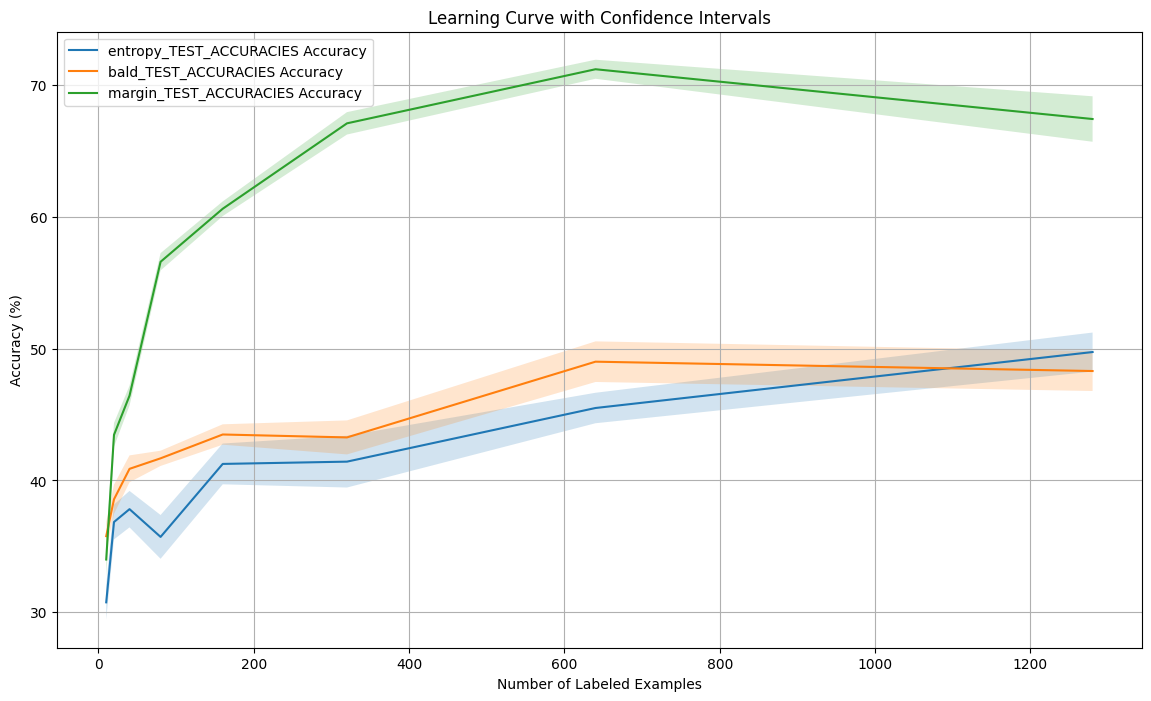

In [ ]:
test_accuracies_dict = {
    "entropy_TEST_ACCURACIES": entropy_TEST_ACCURACIES,
    "bald_TEST_ACCURACIES": Bald_TEST_ACCURACIES,
    "margin_TEST_ACCURACIES": margin_TEST_ACCURACIES

}

len_data = np.array([int(trial[0]) for trial in entropy_TEST_ACCURACIES])

plot_learning_curve_with_ci(test_accuracies_dict, len_data)

## Summary

The Margine Sampling outperforms both Bald and Entropy aquisition both in results and stability, with the increased no. of labeled examples, entropy slightly outperforms Bald Aquisition.